In [1]:
import numpy as np
import torchvision
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger

In [25]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [27]:
data = torchvision.datasets.Food101('/',split = 'train',download = True, transform = transforms.Compose([transforms.Resize((512, 512)),transforms.RandAugment(),transforms.ToTensor(),normalize]))
dataset_size = len(data)
train_size = int(dataset_size * .95)
val_size = dataset_size - train_size
train,val = torch.utils.data.random_split(data,[train_size,val_size])
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=100, shuffle=True,
    num_workers=8, pin_memory=False)
val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=100, shuffle=False,
    num_workers=8, pin_memory=False)

test_dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.Food101('/Users/rahilparmar/Machine Learning', split = 'test',transform=transforms.Compose([                                                                     
        transforms.ToTensor(),
        normalize
    ])),
    batch_size=100, shuffle=False,
    num_workers=8, pin_memory=False)


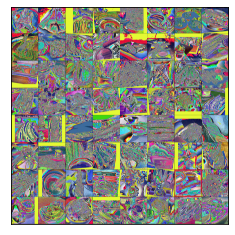

In [29]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

samples = []
for i in range(64):
    if data[i][0].shape == torch.Size([3, 512, 512]):
        samples.append(data[i][0])
grid = torchvision.utils.make_grid(samples)
show(grid)

Model with fully Connected layers

In [30]:
class task1(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,6,4,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6,10,4,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(10*128*128,240),
            nn.ReLU(),
            nn.Linear(in_features = 240,out_features=101),
            nn.ReLU()
        )

    def forward(self,x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-3)

    def training_step(self,train_batch,batch_idx):
        x,y = train_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat,y)
        self.log('train loss',loss)
        return loss

    def validation_step(self,val_batch,batch_idx):
        x,y = val_batch
        x_hat = self.model(x)
        loss = F.cross_entropy(x_hat,y)
        self.log('val_loss',loss)

    def test_step(self,test_batch,batch_idx):
        x,y = test_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(x_hat,y)
        y_hat = torch.argmax(y_hat,dim = 1)
        accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        output = dict({
        'test_loss': loss,
        'test_acc': torch.tensor(accuracy),
        })
        return output
    
    # def backward(self,trainer,loss,optimizer,optimizer_idx=None):
        # loss.backward()

    # def optimizer_step(self,epoch=None,batch_idx=None,optimizer=None,optimizer_idx=None,optimizer_closure=None,on_tpu=None,using_native_amp=None,using_lbfgs=None):
    #     optimizer.step(closure=optimizer_closure) 
    #     optimizer.zero_grad()
        # self.lr_scheduler.step()
        # optimizer.step(closure=None)
        # optimizer.zero_grad()
        # self.lr_scheduler.step()




In [31]:
from torchsummary import summary

In [32]:
model1 = task1()
summary(model1,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 513, 513]             294
              ReLU-2          [-1, 6, 513, 513]               0
         MaxPool2d-3          [-1, 6, 256, 256]               0
            Conv2d-4         [-1, 10, 257, 257]             970
              ReLU-5         [-1, 10, 257, 257]               0
         MaxPool2d-6         [-1, 10, 128, 128]               0
           Flatten-7               [-1, 163840]               0
            Linear-8                  [-1, 240]      39,321,840
              ReLU-9                  [-1, 240]               0
           Linear-10                  [-1, 101]          24,341
             ReLU-11                  [-1, 101]               0
Total params: 39,347,445
Trainable params: 39,347,445
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Fo

In [33]:
logger = TensorBoardLogger("tb_logs", name="model")
trainer =  pl.Trainer(logger = logger,accelerator='gpu',devices=-1,max_epochs=1)
trainer.fit(model1,train_dataloader,val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 39.3 M
-------------------------------------
39.3 M    Trainable params
0         Non-trainable params
39.3 M    Total params
157.390   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12b22e4d0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    # happen when a worker is killed by a signal, e.g., hanging in
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    # See (1) and the second half of the note.
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connecti

In [10]:
trainer.test(model1,test_dataloader)

Testing: 0it [00:00, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 175, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 175, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 140, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


All Convolutional Model

In [34]:
class task2(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,16,4,stride=2),
            nn.ReLU(),
            nn.Conv2d(16,32,4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32,64,4,stride = 2),
            nn.ReLU(),
            nn.Conv2d(64,101,4,stride = 2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def forward(self,x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-3)

    def training_step(self,train_batch,batch_idx):
        x,y = train_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat,y)
        self.log('train loss',loss)
        return loss

    def validation_step(self,val_batch,batch_idx):
        x,y = val_batch
        x_hat = self.model(x)
        loss = F.cross_entropy(x_hat,y)
        self.log('val_loss',loss)

    def test_step(self,test_batch,batch_idx):
        x,y = test_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(x_hat,y)
        y_hat = torch.argmax(y_hat,dim = 1)
        accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        output = dict({
        'test_loss': loss,
        'test_acc': torch.tensor(accuracy),
        })
        return output
    
    # def backward(self,trainer,loss,optimizer,optimizer_idx=None):
        # loss.backward()

    # def optimizer_step(self,epoch=None,batch_idx=None,optimizer=None,optimizer_idx=None,optimizer_closure=None,on_tpu=None,using_native_amp=None,using_lbfgs=None):
    #     optimizer.step(closure=optimizer_closure) 
    #     optimizer.zero_grad()
        # self.lr_scheduler.step()
        # optimizer.step(closure=None)
        # optimizer.zero_grad()
        # self.lr_scheduler.step()





In [35]:
model2 = task2()
summary(model2,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 255]             784
              ReLU-2         [-1, 16, 255, 255]               0
            Conv2d-3         [-1, 32, 126, 126]           8,224
              ReLU-4         [-1, 32, 126, 126]               0
            Conv2d-5           [-1, 64, 62, 62]          32,832
              ReLU-6           [-1, 64, 62, 62]               0
            Conv2d-7          [-1, 101, 30, 30]         103,525
              ReLU-8          [-1, 101, 30, 30]               0
 AdaptiveAvgPool2d-9            [-1, 101, 1, 1]               0
          Flatten-10                  [-1, 101]               0
Total params: 145,365
Trainable params: 145,365
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 28.77
Params size (MB): 0.55
Estimated 

In [36]:
logger = TensorBoardLogger("tb_logs", name="model")
trainer =  pl.Trainer(logger = logger,accelerator='gpu',devices=-1,max_epochs=1)
trainer.fit(model2,train_dataloader,val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 145 K 
-------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.581     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12b22e4d0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    # happen when a worker is killed by a signal, e.g., hanging in
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1445, in _shutdown_workers
    # See (1) and the second half of the note.
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connecti

All Convolutional model with dropout

In [37]:
class task3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,16,4,stride=2),
            nn.ReLU(),
            nn.Conv2d(16,32,4,stride=2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32,64,4,stride = 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64,101,4,stride = 2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

    def forward(self,x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-3)

    def training_step(self,train_batch,batch_idx):
        x,y = train_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat,y)
        self.log('train loss',loss)
        return loss

    def validation_step(self,val_batch,batch_idx):
        x,y = val_batch
        x_hat = self.model(x)
        loss = F.cross_entropy(x_hat,y)
        self.log('val_loss',loss)

    def test_step(self,test_batch,batch_idx):
        x,y = test_batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat,y)
        y_hat = torch.argmax(y_hat,dim = 1)
        accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
        output = dict({
        'test_loss': loss,
        'test_acc': torch.tensor(accuracy),
        })
        return output
    
    # def backward(self,trainer,loss,optimizer,optimizer_idx=None):
        # loss.backward()

    # def optimizer_step(self,epoch=None,batch_idx=None,optimizer=None,optimizer_idx=None,optimizer_closure=None,on_tpu=None,using_native_amp=None,using_lbfgs=None):
    #     optimizer.step(closure=optimizer_closure) 
    #     optimizer.zero_grad()
        # self.lr_scheduler.step()
        # optimizer.step(closure=None)
        # optimizer.zero_grad()
        # self.lr_scheduler.step()





In [39]:
model3 = task3()
summary(model3,(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 255]             784
              ReLU-2         [-1, 16, 255, 255]               0
            Conv2d-3         [-1, 32, 126, 126]           8,224
              ReLU-4         [-1, 32, 126, 126]               0
           Dropout-5         [-1, 32, 126, 126]               0
            Conv2d-6           [-1, 64, 62, 62]          32,832
              ReLU-7           [-1, 64, 62, 62]               0
           Dropout-8           [-1, 64, 62, 62]               0
            Conv2d-9          [-1, 101, 30, 30]         103,525
             ReLU-10          [-1, 101, 30, 30]               0
AdaptiveAvgPool2d-11            [-1, 101, 1, 1]               0
          Flatten-12                  [-1, 101]               0
Total params: 145,365
Trainable params: 145,365
Non-trainable params: 0
-------------------------------

In [40]:

trainer =  pl.Trainer(logger = logger,accelerator='gpu',devices=-1,max_epochs=1)
trainer.fit(model3,train_dataloader,val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory tb_logs/model/version_3/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 145 K 
-------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.581     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Transfer Learning

In [56]:
import torchvision.models as models
from torchmetrics.functional import accuracy

class transferLearning(pl.LightningModule):
    def __init__(self, num_classes=101, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet18(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer

    def validation_step(self,val_batch,batch_idx):
        x, y = val_batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('val_loss', loss)  

In [57]:
model4 = transferLearning()
trainer = pl.Trainer(logger = logger,accelerator='gpu',devices=-1,max_epochs=1)
trainer.fit(model4,train_dataloader,val_dataloader)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rahilparmar/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory tb_logs/model/version_3/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
51.8 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.913    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]